<a href="https://colab.research.google.com/github/costpetrides/FAIRMODE-WG5/blob/main/BaseCASE_Shifted_Grids.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
pip install folium

In [7]:
pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 44.5 MB/s eta 0:00:00


In [12]:
pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 55.1 MB/s eta 0:00:00


# $O_{3}$

In [22]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# --- Φόρτωση των αρχείων ---
nc_file_path = "BaseCase_PERT_O3_YEARLY.nc"
csv_file_path = "yearly_SURF_ppb_O3.csv"

# Φόρτωση του NetCDF
nc_data = xr.open_dataset(nc_file_path)

# Φόρτωση των συντεταγμένων του πλέγματος
lon_values = nc_data["lon"].values
lat_values = nc_data["lat"].values

# Υπολογισμός του βήματος του πλέγματος (grid step)
lon_step = (lon_values[-1] - lon_values[0]) / (len(lon_values) - 1)
lat_step = (lat_values[-1] - lat_values[0]) / (len(lat_values) - 1)

# Μετατόπιση των συντεταγμένων στα κέντρα των κελιών
lon_centered = lon_values + (lon_step / 2)
lat_centered = lat_values + (lat_step / 2)

# Δημιουργία νέου 2D πλέγματος με τις μετατοπισμένες τιμές
grid_points_centered = np.array(np.meshgrid(lon_centered, lat_centered)).T.reshape(-1, 2)

# --- Φόρτωση των δεδομένων των σταθμών ---
station_data = pd.read_csv(csv_file_path)

# Ανάκτηση των συντεταγμένων των σταθμών
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values

# --- Εύρεση πλησιέστερου κελιού στο μετατοπισμένο πλέγμα ---
tree_centered = cKDTree(grid_points_centered)
distances, indices = tree_centered.query(np.column_stack((station_lons, station_lats)))

# Εύρεση των πλησιέστερων μετατοπισμένων συντεταγμένων
nearest_lons = grid_points_centered[indices, 0]
nearest_lats = grid_points_centered[indices, 1]

# --- Αντιστοίχιση των τιμών PM2.5 ---
# Εξαγωγή συγκεντρώσεων PM2.5 από το NetCDF
pm25_values = nc_data["SURF_ppb_O3"].values.squeeze()
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
grid_points_pm25 = np.column_stack((lon_grid.ravel(), lat_grid.ravel(), pm25_values.ravel()))

# Χρήση KDTree για εύρεση της αντίστοιχης συγκέντρωσης PM2.5 στο πλησιέστερο κελί
pm25_tree = cKDTree(grid_points_pm25[:, :2])
_, indices_pm25 = pm25_tree.query(np.column_stack((nearest_lons, nearest_lats)))
nearest_pm25 = grid_points_pm25[indices_pm25, 2]

# --- Δημιουργία τελικού DataFrame ---
df_shifted = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "SURF_ppb_O3": station_data["SURF_ppb_O3"].values,
    "nearest_lon": nearest_lons,
    "nearest_lat": nearest_lats,
    "nearest_SURF_ppb_O3": nearest_pm25
})

# --- Αποθήκευση σε CSV ---
shifted_file = "shifted_O3.csv"
df_shifted.to_csv(shifted_file, index=False)

print(f"Το αρχείο αποθηκεύτηκε ως: {shifted_file}")

Το αρχείο αποθηκεύτηκε ως: shifted_O3.csv


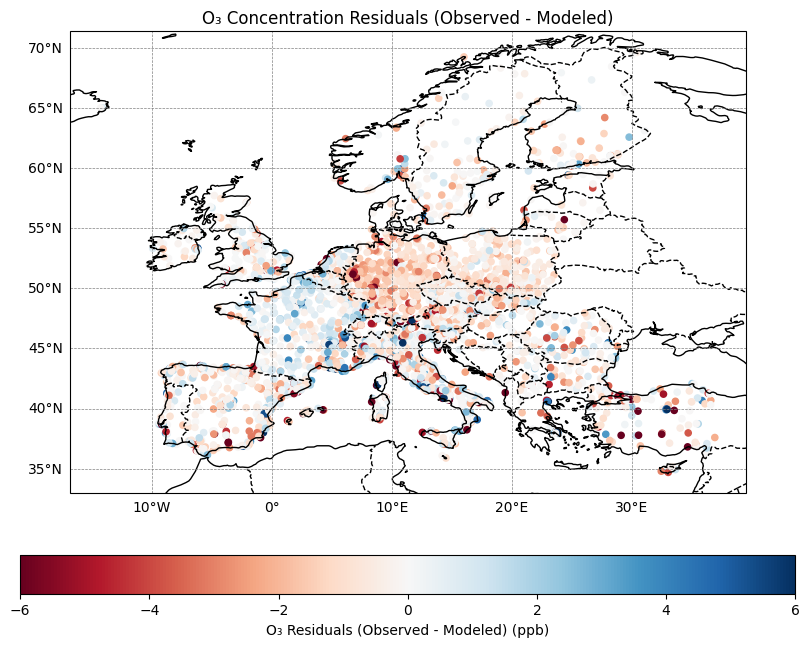

In [25]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("shifted_O3.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["O3_residuals"] = stations["SURF_ppb_O3"] - stations["nearest_SURF_ppb_O3"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["O3_residuals"],
    cmap="RdBu",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors= None,
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("O₃ Residuals (Observed - Modeled) (ppb)")

# Τίτλος
ax.set_title("O₃ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()


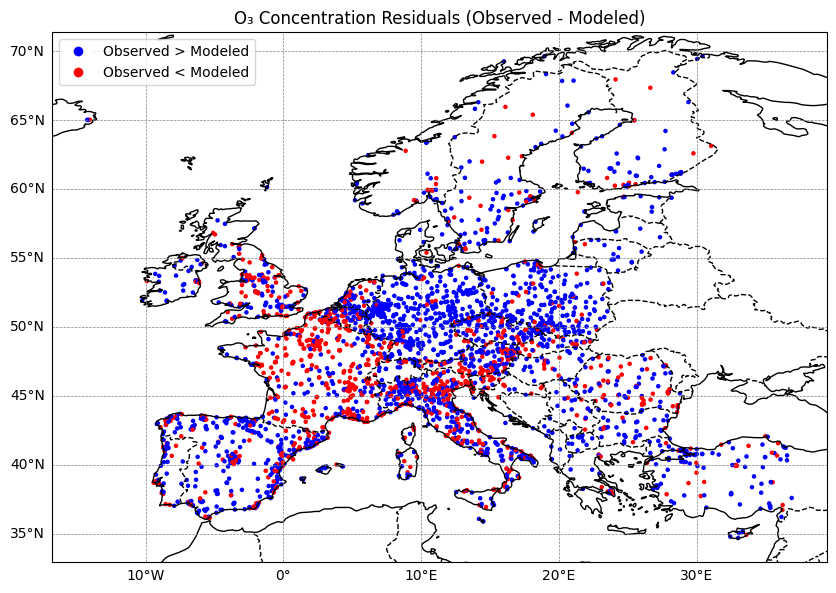

In [44]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("shifted_O3.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["O3_residuals"] = stations["SURF_ppb_O3"] - stations["nearest_SURF_ppb_O3"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["O3_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με δύο χρώματα (μπλε = θετικά, κόκκινο = αρνητικά)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors=None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)

# Προσθήκη υπομνήματος
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label="Observed > Modeled"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label="Observed < Modeled")
]
ax.legend(handles=legend_elements, loc="upper left")

# Τίτλος
ax.set_title("O₃ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

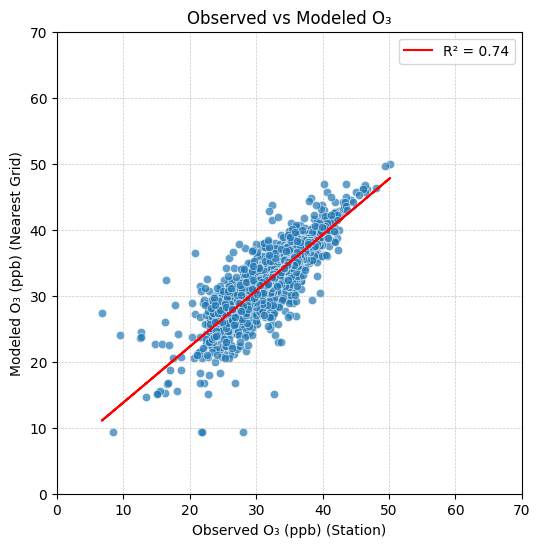

Mean Absolute Error (MAE): 1.43
Root Mean Squared Error (RMSE): 2.29


In [28]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("shifted_O3.csv")

# Extract observed and modeled PM2.5 values
observed_O3 = stations["SURF_ppb_O3"]
modeled_O3 = stations["nearest_SURF_ppb_O3"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_O3, modeled_O3)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_O3, y=modeled_O3, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_O3, slope * observed_O3 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed O₃ (ppb) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled O₃ (ppb) (Nearest Grid)")
plt.title("Observed vs Modeled O₃")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_O3, modeled_O3)
rmse = np.sqrt(mean_squared_error(observed_O3, modeled_O3))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# $NO_{2}$

In [29]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# --- Φόρτωση των αρχείων ---
nc_file_path = "BaseCase_PERT_NO2_YEARLY.nc"
csv_file_path = "yearly_SURF_ug_NO2.csv"

# Φόρτωση του NetCDF
nc_data = xr.open_dataset(nc_file_path)

# Φόρτωση των συντεταγμένων του πλέγματος
lon_values = nc_data["lon"].values
lat_values = nc_data["lat"].values

# Υπολογισμός του βήματος του πλέγματος (grid step)
lon_step = (lon_values[-1] - lon_values[0]) / (len(lon_values) - 1)
lat_step = (lat_values[-1] - lat_values[0]) / (len(lat_values) - 1)

# Μετατόπιση των συντεταγμένων στα κέντρα των κελιών
lon_centered = lon_values + (lon_step / 2)
lat_centered = lat_values + (lat_step / 2)

# Δημιουργία νέου 2D πλέγματος με τις μετατοπισμένες τιμές
grid_points_centered = np.array(np.meshgrid(lon_centered, lat_centered)).T.reshape(-1, 2)

# --- Φόρτωση των δεδομένων των σταθμών ---
station_data = pd.read_csv(csv_file_path)

# Ανάκτηση των συντεταγμένων των σταθμών
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values

# --- Εύρεση πλησιέστερου κελιού στο μετατοπισμένο πλέγμα ---
tree_centered = cKDTree(grid_points_centered)
distances, indices = tree_centered.query(np.column_stack((station_lons, station_lats)))

# Εύρεση των πλησιέστερων μετατοπισμένων συντεταγμένων
nearest_lons = grid_points_centered[indices, 0]
nearest_lats = grid_points_centered[indices, 1]

# --- Αντιστοίχιση των τιμών PM2.5 ---
# Εξαγωγή συγκεντρώσεων PM2.5 από το NetCDF
pm25_values = nc_data["SURF_ug_NO2"].values.squeeze()
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
grid_points_pm25 = np.column_stack((lon_grid.ravel(), lat_grid.ravel(), pm25_values.ravel()))

# Χρήση KDTree για εύρεση της αντίστοιχης συγκέντρωσης PM2.5 στο πλησιέστερο κελί
pm25_tree = cKDTree(grid_points_pm25[:, :2])
_, indices_pm25 = pm25_tree.query(np.column_stack((nearest_lons, nearest_lats)))
nearest_pm25 = grid_points_pm25[indices_pm25, 2]

# --- Δημιουργία τελικού DataFrame ---
df_shifted = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "SURF_ug_NO2": station_data["SURF_ug_NO2"].values,
    "nearest_lon": nearest_lons,
    "nearest_lat": nearest_lats,
    "nearest_SURF_ug_NO2": nearest_pm25
})

# --- Αποθήκευση σε CSV ---
shifted_file = "shifted_NO2.csv"
df_shifted.to_csv(shifted_file, index=False)

print(f"Το αρχείο αποθηκεύτηκε ως: {shifted_file}")

Το αρχείο αποθηκεύτηκε ως: shifted_NO2.csv


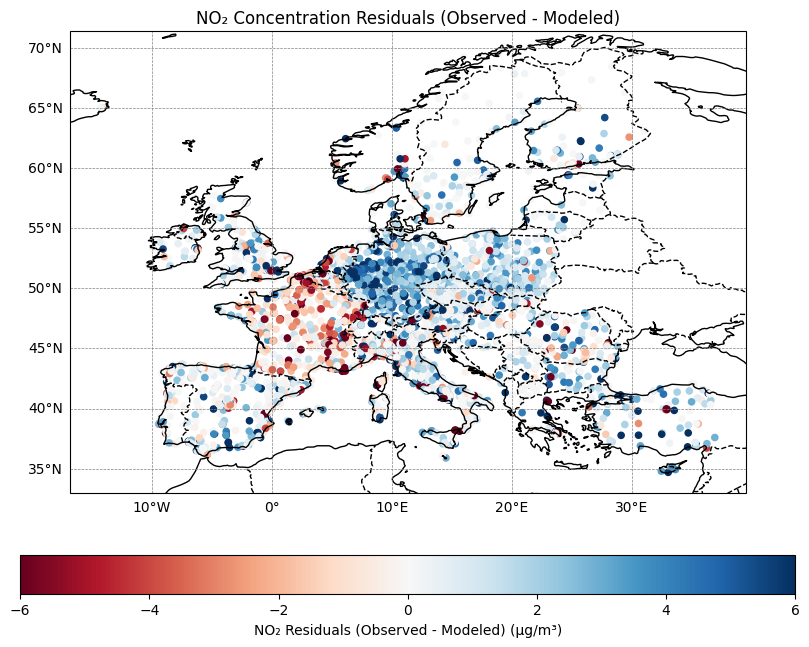

In [31]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("shifted_NO2.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["NO2_residuals"] = stations["SURF_ug_NO2"] - stations["nearest_SURF_ug_NO2"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["NO2_residuals"],
    cmap="RdBu",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors= None,
    s=20,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("NO₂ Residuals (Observed - Modeled) (µg/m³)")

# Τίτλος
ax.set_title("NO₂ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

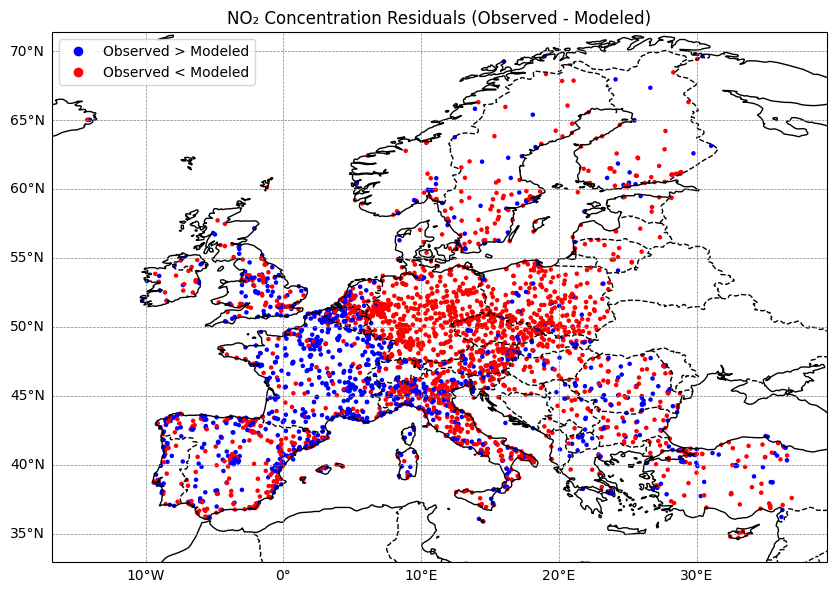

In [43]:

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("shifted_NO2.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["NO2_residuals"] = stations["SURF_ug_NO2"] - stations["nearest_SURF_ug_NO2"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["NO2_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με δύο χρώματα (μπλε = θετικά, κόκκινο = αρνητικά)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors=None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)

# Προσθήκη υπομνήματος
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label="Observed > Modeled"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label="Observed < Modeled")
]
ax.legend(handles=legend_elements, loc="upper left")

# Τίτλος
ax.set_title("NO₂ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

# $PM_{2.5}$

In [3]:
import xarray as xr
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# --- Φόρτωση των αρχείων ---
nc_file_path = "BaseCase_PERT_PM25_rh50_YEARLY.nc"
csv_file_path = "yearly_SURF_ug_PM25_rh50.csv"

# Φόρτωση του NetCDF
nc_data = xr.open_dataset(nc_file_path)

# Φόρτωση των συντεταγμένων του πλέγματος
lon_values = nc_data["lon"].values
lat_values = nc_data["lat"].values

# Υπολογισμός του βήματος του πλέγματος (grid step)
lon_step = (lon_values[-1] - lon_values[0]) / (len(lon_values) - 1)
lat_step = (lat_values[-1] - lat_values[0]) / (len(lat_values) - 1)

# Μετατόπιση των συντεταγμένων στα κέντρα των κελιών
lon_centered = lon_values + (lon_step / 2)
lat_centered = lat_values + (lat_step / 2)

# Δημιουργία νέου 2D πλέγματος με τις μετατοπισμένες τιμές
grid_points_centered = np.array(np.meshgrid(lon_centered, lat_centered)).T.reshape(-1, 2)

# --- Φόρτωση των δεδομένων των σταθμών ---
station_data = pd.read_csv(csv_file_path)

# Ανάκτηση των συντεταγμένων των σταθμών
station_lons = station_data["lon"].values
station_lats = station_data["lat"].values

# --- Εύρεση πλησιέστερου κελιού στο μετατοπισμένο πλέγμα ---
tree_centered = cKDTree(grid_points_centered)
distances, indices = tree_centered.query(np.column_stack((station_lons, station_lats)))

# Εύρεση των πλησιέστερων μετατοπισμένων συντεταγμένων
nearest_lons = grid_points_centered[indices, 0]
nearest_lats = grid_points_centered[indices, 1]

# --- Αντιστοίχιση των τιμών PM2.5 ---
# Εξαγωγή συγκεντρώσεων PM2.5 από το NetCDF
pm25_values = nc_data["SURF_ug_PM25_rh50"].values.squeeze()
lon_grid, lat_grid = np.meshgrid(lon_values, lat_values)
grid_points_pm25 = np.column_stack((lon_grid.ravel(), lat_grid.ravel(), pm25_values.ravel()))

# Χρήση KDTree για εύρεση της αντίστοιχης συγκέντρωσης PM2.5 στο πλησιέστερο κελί
pm25_tree = cKDTree(grid_points_pm25[:, :2])
_, indices_pm25 = pm25_tree.query(np.column_stack((nearest_lons, nearest_lats)))
nearest_pm25 = grid_points_pm25[indices_pm25, 2]

# --- Δημιουργία τελικού DataFrame ---
df_shifted = pd.DataFrame({
    "lon": station_lons,
    "lat": station_lats,
    "SURF_ug_PM25_rh50": station_data["SURF_ug_PM25_rh50"].values,
    "nearest_lon": nearest_lons,
    "nearest_lat": nearest_lats,
    "nearest_SURF_ug_PM25_rh50": nearest_pm25
})

# --- Αποθήκευση σε CSV ---
shifted_file = "shifted_PM25.csv"
df_shifted.to_csv(shifted_file, index=False)

print(f"Το αρχείο αποθηκεύτηκε ως: {shifted_file}")

Το αρχείο αποθηκεύτηκε ως: shifted_PM25.csv


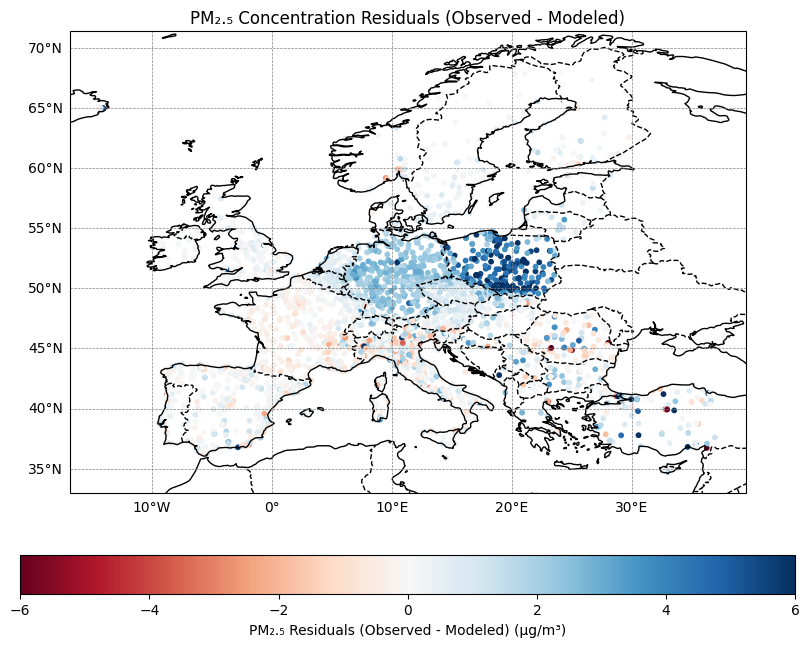

In [40]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("shifted_PM25.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["PM25_residuals"] = stations["SURF_ug_PM25_rh50"] - stations["nearest_SURF_ug_PM25_rh50"]

# Ορισμός των ορίων της χρωματικής κλίμακας
cbar_min = -6
cbar_max = 6

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals NO₂ με χρωματική κλίμακα RdBu (το 0 στο λευκό)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=stations["PM25_residuals"],
    cmap="RdBu",
    vmin=cbar_min,
    vmax=cbar_max,
    edgecolors= None,
    s=10,
    transform=ccrs.PlateCarree()
)

# Προσθήκη οριζόντιας χρωματικής κλίμακας κάτω από το σχήμα
cbar = plt.colorbar(sc, ax=ax, orientation="horizontal", pad=0.1)
cbar.set_label("PM₂.₅ Residuals (Observed - Modeled) (µg/m³)")

# Τίτλος
ax.set_title("PM₂.₅ Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

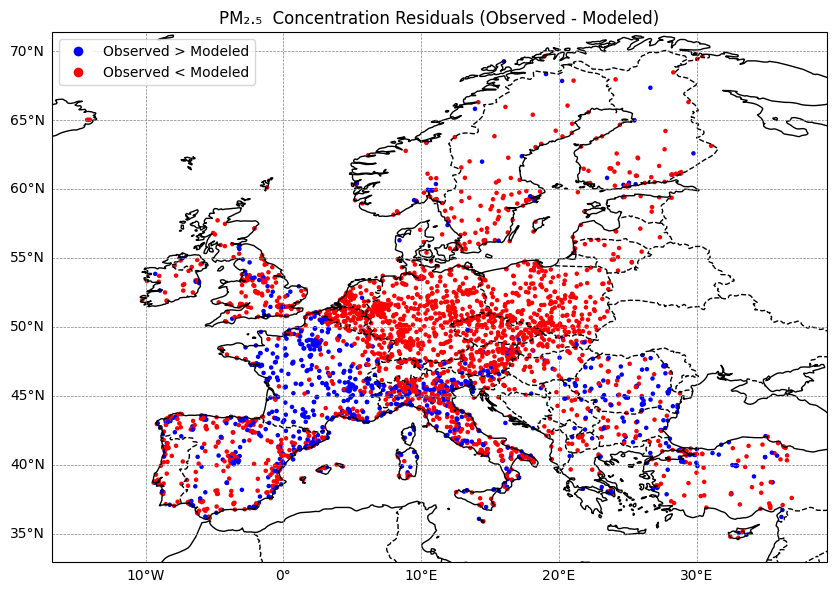

In [42]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd

# Φόρτωση των δεδομένων
stations = pd.read_csv("shifted_PM25.csv")

# Υπολογισμός των residuals ως (Observed - Modeled)
stations["PM25_residuals"] = stations["SURF_ug_PM25_rh50"] - stations["nearest_SURF_ug_PM25_rh50"]

# Ορισμός χρώματος ανάλογα με το πρόσημο των residuals
colors = stations["PM25_residuals"].apply(lambda x: "red" if x > 0 else "blue")

# Δημιουργία χάρτη
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={"projection": ccrs.PlateCarree()})

# Προσθήκη συνόρων και ακτογραμμών
ax.add_feature(cfeature.BORDERS, linestyle="--", edgecolor="black", linewidth=1)
ax.coastlines(resolution="50m", linewidth=1)

# Προσθήκη γραμμών πλέγματος
gl = ax.gridlines(draw_labels=True, linestyle="--", linewidth=0.5, color="gray")
gl.top_labels = False  # Αφαίρεση ετικετών στην κορυφή
gl.right_labels = False  # Αφαίρεση ετικετών στα δεξιά

# Προβολή των residuals O₃ με δύο χρώματα (μπλε = θετικά, κόκκινο = αρνητικά)
sc = ax.scatter(
    stations["lon"],
    stations["lat"],
    c=colors,
    edgecolors=None,
    s=5,  # Σταθερό μέγεθος σημείων
    transform=ccrs.PlateCarree()
)

# Προσθήκη υπομνήματος
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label="Observed > Modeled"),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label="Observed < Modeled")
]
ax.legend(handles=legend_elements, loc="upper left")

# Τίτλος
ax.set_title("PM₂.₅  Concentration Residuals (Observed - Modeled)")

# Εμφάνιση χάρτη
plt.show()

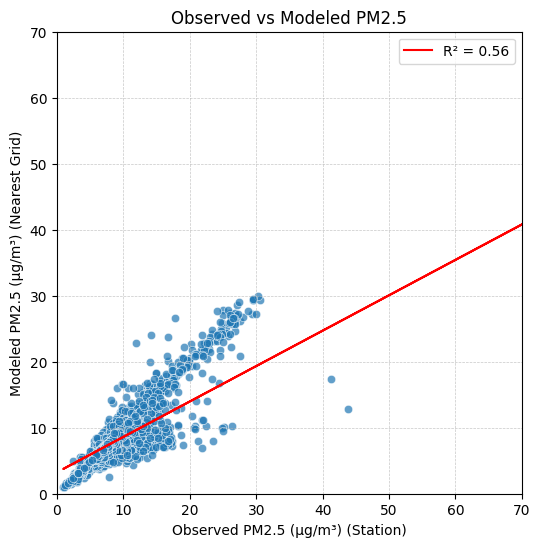

Mean Absolute Error (MAE): 1.40
Root Mean Squared Error (RMSE): 4.06


In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error  # Import missing functions

# Load the dataset
stations = pd.read_csv("shifted_PM25.csv")

# Extract observed and modeled PM2.5 values
observed_pm25 = stations["SURF_ug_PM25_rh50"]
modeled_pm25 = stations["nearest_SURF_ug_PM25_rh50"]

# Perform linear regression
slope, intercept, r_value, p_value, std_err = linregress(observed_pm25, modeled_pm25)

# Calculate R-squared
r_squared = r_value**2

# Create the scatter plot with grid
plt.figure(figsize=(6, 6))
sns.scatterplot(x=observed_pm25, y=modeled_pm25, alpha=0.7)

# Plot the regression line with R² label
plt.plot(observed_pm25, slope * observed_pm25 + intercept, color='red', label=f"R² = {r_squared:.2f}")

# Labels, title, and grid
plt.xlabel("Observed PM2.5 (µg/m³) (Station)")
plt.xlim(0, 70)
plt.ylim(0, 70)
plt.ylabel("Modeled PM2.5 (µg/m³) (Nearest Grid)")
plt.title("Observed vs Modeled PM2.5")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()

# Compute error metrics
mae = mean_absolute_error(observed_pm25, modeled_pm25)
rmse = np.sqrt(mean_squared_error(observed_pm25, modeled_pm25))

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")